# Grouping districts of Lima Metropolitana into zones

I'll use geopandas to group districts of Lima Metropolitana into zones.

Importing my libraries:

In [1]:
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt

I'll start by reading an `xlsX` file with the district populations according to the last census. This file comes from the website of INEI, the National Institute of Statistics of Peru. INEI's files, when they are not survey microdata, are often very messy. That's the case here, and I'll use some data munging to normalize my data in a districts dataframe.

## Arranging district population data

First, I'll export the file. I use a custom configuration to export only the portion of it that I'm insterested in.

In [2]:
population_file = '../../data/raw/poblacion distrital lima_censo2017.xlsX'
population_df = pd.read_excel(population_file,
                              skiprows = 8,
                              skipfooter = 10,
                              usecols = [1, 2])
population_df = population_df.rename(columns = {'Unnamed: 1': 'IDDIST', 'Unnamed: 2': 'population'})
population_df.head()

,IDDIST,population
0,AREA # 150101,"Lima, Lima, distrito: Lima"
1,NaN,NaN
2,P: Área concepto encuesta,Casos
3,Urbano encuesta,273142
4,Total,273142


This file contains a lot of unnecessary cells. After a visual inspection, I'll proceed with normalizing this dataframe and keeping only the relevant rows.

In [3]:
population_df = population_df[(population_df['IDDIST'] == 'Total') | population_df['IDDIST'].str.contains('AREA #')].reset_index(drop = True)
population_df['population'] = population_df.loc[1:]['population'].reset_index(drop = True)
population_df = population_df[population_df['IDDIST'].str.contains('AREA #')].reset_index(drop = True)
population_df.head()

,IDDIST,population
0,AREA # 150101,273142
1,AREA # 150102,67232
2,AREA # 150103,624172
3,AREA # 150104,35379
4,AREA # 150105,90414


The result we have so far also contains districts of the Lima department that are outside of Lima Metropolitana. Now I'll drop those out and also will only keep the corresponding ID in `IDDIST`.

In [4]:
population_df['IDDIST'] = population_df['IDDIST'].apply(lambda x: re.sub('AREA # ', '', x))
population_df = population_df[population_df['IDDIST'].apply(lambda x: x[:4] == '1501')]
population_df['population'] = population_df['population'].astype('int32')

In [5]:
population_df.head()

,IDDIST,population
0,150101,273142
1,150102,67232
2,150103,624171
3,150104,35378
4,150105,90413


Great. Now I'll replicate this result with the districts of Callao (the port of Lima). Though Callao is a separate department than Lima, it's also part of Lima Metropolitana.

In [6]:
callao_population_file = '../../data/raw/poblacion distrital callao_censo2017.xlsX'
callao_population_df = pd.read_excel(callao_population_file,
                              skiprows = 8,
                              skipfooter = 9,
                              usecols = [1, 2])
callao_population_df = callao_population_df.rename(columns = {'Unnamed: 1': 'IDDIST', 'Unnamed: 2': 'population'})

In [7]:
callao_population_df = callao_population_df[(callao_population_df['IDDIST'] == 'Total') | callao_population_df['IDDIST'].str.contains('AREA #')].reset_index(drop = True)
callao_population_df['population'] = callao_population_df.loc[1:]['population'].reset_index(drop = True)
callao_population_df = callao_population_df[callao_population_df['IDDIST'].str.contains('AREA #')].reset_index(drop = True)

In [8]:
callao_population_df['IDDIST'] = callao_population_df['IDDIST'].apply(lambda x: re.sub('AREA # ', '', x))
callao_population_df['population'] = callao_population_df['population'].astype('int32')

In [9]:
callao_population_df.head()

,IDDIST,population
0,070101,479418
1,070102,77679
2,070103,44376
3,070104,62387
4,070105,3926


Finally, I'll merge both `population_df` and `callao_population_df`, overwriting the first.

In [10]:
population_df = pd.concat([callao_population_df, population_df]).reset_index(drop = True)
population_df.head()

,IDDIST,population
0,070101,479418
1,070102,77679
2,070103,44376
3,070104,62387
4,070105,3926


Nice result.

# Districts GIS data

I'll continue by importing the GIS data of the districts of Peru, conveniently stored in a shapefile downloaded from the INEI 2013 Poverty Map microdata repository.

In [11]:
districts_file = '../../data/raw/GIS/03 Limite Distrital Abril 2015/DISTRITO_27_04_2015.shp'
districts_df = gpd.read_file(districts_file)

This shapefile contains all the districts of Peru. I'll filter only the districts in Lima Metropolitana.

In [12]:
districts_lima_df = districts_df[(districts_df['IDPROV'] == '1501') | (districts_df['IDDPTO'] == '07')].reset_index()

Now I'll keep only the columns relevant for me.

In [13]:
cols_to_keep = ['IDDIST',
                'NOMBDIST',
                'geometry']
districts_lima_df = districts_lima_df[cols_to_keep]
districts_lima_df.head()

,IDDIST,NOMBDIST,geometry
0,150119,LURIN,POLYGON ((-76.93986323599995 -12.2477324799998...
1,150102,ANCON,POLYGON ((-77.00476011945636 -11.6142695392331...
2,150131,SAN ISIDRO,POLYGON ((-77.02281236099998 -12.0908106049999...
3,150120,MAGDALENA DEL MAR,POLYGON ((-77.06314261199998 -12.0865429789999...
4,150130,SAN BORJA,POLYGON ((-76.98169136199994 -12.0846288549999...


Then I'll do an inner merge to add a column with the population of each district. In both `districts_lima_df` and `population_df` the number of districts is 50.

In [14]:
len(districts_lima_df) == len(population_df)

True

In [15]:
len(districts_lima_df)

50

Merging:

In [16]:
districts_lima_df = pd.merge(districts_lima_df, population_df, how='inner', on='IDDIST')
districts_lima_df.head()

,IDDIST,NOMBDIST,geometry,population
0,150119,LURIN,POLYGON ((-76.93986323599995 -12.2477324799998...,97502
1,150102,ANCON,POLYGON ((-77.00476011945636 -11.6142695392331...,67232
2,150131,SAN ISIDRO,POLYGON ((-77.02281236099998 -12.0908106049999...,65332
3,150120,MAGDALENA DEL MAR,POLYGON ((-77.06314261199998 -12.0865429789999...,61655
4,150130,SAN BORJA,POLYGON ((-76.98169136199994 -12.0846288549999...,121792


Now I'll define the groups of districts I'll merge into zones. The generation of these zones is somewhat arbitrary, but it's mainly based on geographical proximity and accesibility between districts. It's worth noting that this is a work in progress and changes to this grouping may occur.

In [17]:
south = ['LURIN',
         'VILLA MARIA DEL TRIUNFO',
         'SAN JUAN DE MIRAFLORES',
         'VILLA EL SALVADOR',
         'PACHACAMAC']
north = ['ANCON',
         'SANTA ROSA',
         'CARABAYLLO',
         'INDEPENDENCIA',
         'SAN MARTIN DE PORRES',
         'PUENTE PIEDRA',
         'LOS OLIVOS',
         'COMAS']
east = ['SANTA ANITA',
        'CIENEGUILLA',
        'ATE',
        'LURIGANCHO',
        'CHACLACAYO']
high_income = ['SAN ISIDRO',
               'MAGDALENA DEL MAR',
               'SAN BORJA',
               'LINCE',
               'SANTIAGO DE SURCO',
               'PUEBLO LIBRE',
               'JESUS MARIA',
               'BARRANCO',
               'MIRAFLORES',
               'SURQUILLO',
               'SAN MIGUEL',
               'LA MOLINA',
               'SAN LUIS',
               'CHORRILLOS']
port = ['LA PUNTA',
        'LA PERLA',
        'BELLAVISTA',
        'CARMEN DE LA LEGUA REYNOSO',
        'CALLAO',
        'VENTANILLA',
        'MI PERU']
old_town = ['LA VICTORIA',
            'BREÑA',
            'LIMA',
            'EL AGUSTINO',
            'RIMAC']
sjl = ['SAN JUAN DE LURIGANCHO']
south_beach = ['PUCUSANA',
               'PUNTA HERMOSA',
               'PUNTA NEGRA',
               'SAN BARTOLO',
               'SANTA MARIA DEL MAR']

Mapping the districts to the zones in a new column named `zone`:

In [18]:
districts_lima_df['zone'] = ''
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(north)] = 'North Lima'
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(south)] = 'South Lima'
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(east)] = 'East Lima'
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(high_income)] = 'High income Lima'
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(port)] = 'Port'
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(old_town)] = 'Old town'
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(sjl)] = 'San Juan de Lurigancho'
districts_lima_df['zone'].loc[districts_lima_df['NOMBDIST'].isin(south_beach)] = 'South beach'

/home/luis_eduardo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
districts_lima_df.head()

,IDDIST,NOMBDIST,geometry,population,zone
0,150119,LURIN,POLYGON ((-76.93986323599995 -12.2477324799998...,97502,South Lima
1,150102,ANCON,POLYGON ((-77.00476011945636 -11.6142695392331...,67232,North Lima
2,150131,SAN ISIDRO,POLYGON ((-77.02281236099998 -12.0908106049999...,65332,High income Lima
3,150120,MAGDALENA DEL MAR,POLYGON ((-77.06314261199998 -12.0865429789999...,61655,High income Lima
4,150130,SAN BORJA,POLYGON ((-76.98169136199994 -12.0846288549999...,121792,High income Lima


Before proceeding, I'll save the `IDDIST` to `zone` mapping in a csv file -- I'm gonna need it later for other visualizations.

In [20]:
districts_lima_df[['IDDIST', 'zone']].to_csv('../../data/clean/iddist_zone_lima.csv', index=False)

## Final merge of districts into zones

First, I'll plot the original districts division:

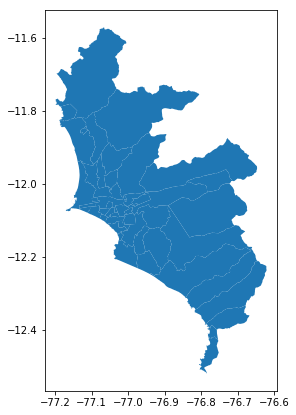

In [21]:
districts_lima_df.plot(figsize=(7, 7))

Looks good. Now, I'll dissolve the districts into the zones I previously defined:

In [22]:
districts_lima_df['geometry'] = districts_lima_df['geometry'].buffer(0.0001)
zones_lima_df = districts_lima_df.dissolve(by='zone', aggfunc='sum').reset_index()
zones_lima_df

,zone,geometry,population
0,East Lima,POLYGON ((-76.72221422013411 -11.9996242552709...,1172820
1,High income Lima,POLYGON ((-77.0397784844929 -12.19333550502605...,1800812
2,North Lima,POLYGON ((-77.03055437207536 -11.9963939450321...,2623415
3,Old town,POLYGON ((-77.00303420170269 -12.0625560448050...,943812
4,Port,POLYGON ((-77.1682220185275 -12.07085061237087...,1046951
5,San Juan de Lurigancho,POLYGON ((-76.93129909940232 -11.9422455853702...,1114318
6,South Lima,POLYGON ((-76.66194278681792 -12.1780103824127...,1458644
7,South beach,POLYGON ((-76.80280281144788 -12.4806145253400...,48479


Taking a peek at the result by population:

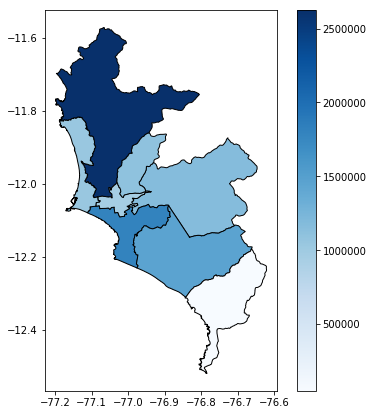

In [23]:
zones_lima_df.plot(figsize=(7, 7), column='population', legend=True, cmap='Blues', edgecolor='Black')

Bingo. Finally, I export the results.

In [24]:
zones_lima_df.to_file('../../data/clean/zones_lima.geojson', driver='GeoJSON', index=False)